**TODO vol surf**:
<br/>. enlarge
<br/>. make surface more visible / understandable
<br/>. use wire grid, not color surface
<br/>. figure title and axis titles

In [2]:
# used in the current notebook
PAR = {}


# Related definitions for this topic

## Moneyness of an option

In the money: with the current spot price of the underlying the option will pay

Out of the money: $\,S_0<K\,$ for call and $\,S_0>K\,$ for put.

At the money (ATM): $\,S_0=K\,$.

## Over the counter (OTC)

Contracts are usually made
* either `at exchanges` through marketmakers, with fixed conditions and reduced risk,
* or directly between two sides, that is, `OTC` (over-the-counter), with tailored conditions and higher risk.

## Open interest

For a standardized contract type, this is the number of currently active contracts of this type.

# Volatility smile
Display the volatility smile for one selected ticker with NYSE data from Yahoo Finance.

## Observe and Download the data

1. Go to Yahoo Finance > Microsoft > Options at
<br/>https://finance.yahoo.com/quote/MSFT/options


2. Observe that each row displays information about one standardized contract type.


3. Download the webpage as a single html to the `data` subfolder of your current folder.
<br/>
The name of the downloaded file is "Microsoft Corporation (MSFT) Options Chain - Yahoo Finance.html".


## Plot Implied volatility and Open interest

Process the downloaded html file with the code below.


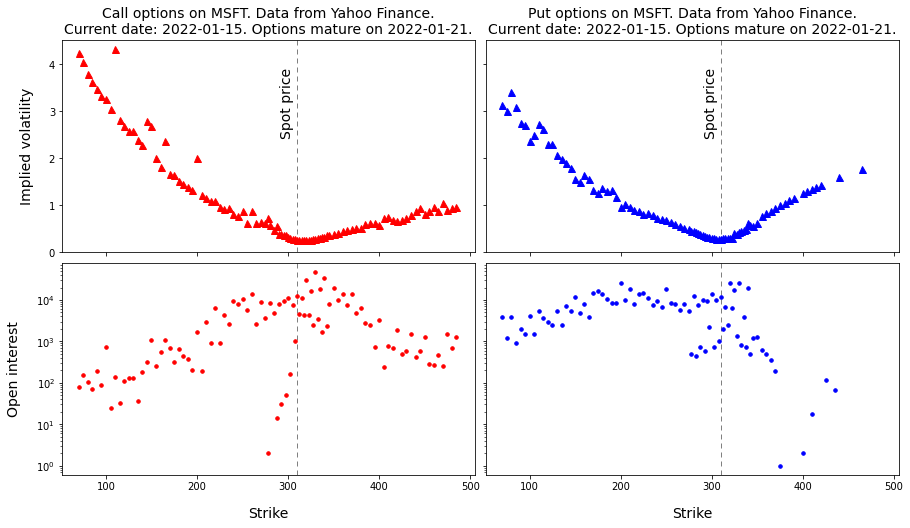

In [3]:
from collections import OrderedDict
from datetime import datetime
from glob import glob
from matplotlib import pyplot as plt
from os.path import join
import re

PAR['vol_smile'] = {
    'data_dir': 'data',
    'stock_ticker': 'MSFT',
    'data_file_name': 'Microsoft Corporation (MSFT) Options Chain - Yahoo Finance.html',
    'figure_size': (15, 8),
    'option_types': ['call', 'put'],
    'color_list': ['red', 'blue'],
    'fontsize': 14,
    'label_pad': 15,
    'ticks_fontsize': 13,
    'subplots_width_space': 0.025,
    'subplots_height_space': 0.05,
    'spot_color': 'gray',
    'spot_line_width': 1,
    'spot_dash_length': (5, 4)
}


def parse_yahoo_options_data(par=None, html_str=None):
    """
    Parse options data received from finance.yahoo.com
    """

    options_data = {option_type: [] for option_type in par['option_types']}

    # get spot
    price_match = re.search('postMarketPrice\":{\"raw\":(.+?),', html_str)
    if price_match:
        post_market_price = float(price_match.group(1))
    else:
        raise ValueError(f'Cannot find post market price in {infile}')

    # get current time
    time_match = re.search('postMarketTime\":(\d+)', html_str)
    if time_match:
        post_market_time = int(time_match.group(1))
    else:
        raise ValueError(f'Cannot find post market time in {infile}')

    # get maturity
    maturity_match = re.search(par['stock_ticker'] + '(\d{6})(C|P)', html_str)
    if maturity_match:
        maturity = maturity_match.group(1)
    else:
        raise ValueError(f'Cannot find maturity in {infile}')

    # get option data
    options_match = re.match('^.*?<table class=\"calls.+?<tbody.*?>(?P<call>.*?)<\/tbody>'
                             '.*?<table class=\"puts.+?<tbody.*?>(?P<put>.*?)<\/tbody>', 
                             html_str, re.DOTALL)  # matches saved by names: call, put
    if options_match:
        html_tables = {c: options_match.group(c) for c in par['option_types']}
        for option_type, option_table_body in html_tables.items():
            for table_line_match in re.finditer(r'<td class=\"data-col2.*?><a.*?>(.+?)<\/a>.*?'
                                                r'<td class=\"data-col9.*?>(.+?)<\/td>.*?'
                                                r'<td class=\"data-col10.*?>(.+?)\%<\/td>',
                                                option_table_body):
                strike, open_interest, implied_volatility = (
                    [x.replace(',', '') for x in table_line_match.group(1, 2, 3)])
                options_data[option_type].append({
                    'strike': float(strike),
                    'open interest': None if open_interest == '-' else int(open_interest),
                    'implied volatility': round(float(implied_volatility) * 0.01, 4)
                })
    else:
        raise ValueError(f'Cannot find call and put tables in {infile}')
            
    return {'post_market_time': post_market_time, 'post_market_price': post_market_price,
            'maturity': maturity, 'options_data': options_data}

            
def plot_options_impl_vol_open_interest(par=None, vol_smile_data=None):
    """
    Plot an analysis of the implied volatility and open interest
    """
    post_market_time = vol_smile_data['post_market_time']
    post_market_price = vol_smile_data['post_market_price']
    maturity = vol_smile_data['maturity']
    options_data = vol_smile_data['options_data']
    
    # --- settings ---
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=par['figure_size'])    
    [plt.rc(t, labelsize=par['ticks_fontsize']) for t in ['xtick', 'ytick']]
    implied_vol_plot_max = {}
    open_interest_plot_limits = {}
    strike_plot_limits = []
    
    # --- compiling data and plotting ---
    for column_index, option_type in enumerate(par['option_types']):

        # --- implied volatility ---
        ax = axes[0][column_index]
        strikes = []
        impl_vols = []
        for dat in options_data[option_type]:
            if dat['implied volatility'] is not None and dat['implied volatility'] > 0.0:
                strikes.append(dat['strike'])
                impl_vols.append(dat['implied volatility'])
        ax.axvline(post_market_price, color=par['spot_color'], linewidth=par['spot_line_width'],
                   linestyle='--', dashes=par['spot_dash_length'])
        ax.plot(strikes, impl_vols, linestyle='-', label='Implied volatility', 
                color=par['color_list'][column_index], marker='^', linewidth=0, markersize=7)
        
        implied_vol_plot_max[option_type] = ax.get_ylim()[1]  
        strike_plot_limits.append(ax.get_xlim())

        # how to display the post market date and the maturity
        maturity_displayed = '-'.join(['20' + maturity[:2], maturity[2:4], maturity[4:6]])
        post_market_date = datetime.fromtimestamp(post_market_time)
        post_market_date_displayed = '-'.join([str(post_market_date.year),
                                               str(post_market_date.month).zfill(2),
                                               str(post_market_date.day).zfill(2)])
        
        ax.set_title(f'{option_type.capitalize()} options on {par["stock_ticker"]}. Data from Yahoo Finance.\n' 
                     f'Current date: {post_market_date_displayed}. Options mature on {maturity_displayed}.',
                     fontsize=par['fontsize'])
        if column_index == 0:  # show the y axis label only on the left subplot
            ax.set_ylabel('Implied volatility', fontsize=par['fontsize'], labelpad=par['label_pad'])
        else:  # hide y ticks if we are not at the left subplot
            ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=False)
        # hide x ticks in the first row
        ax.tick_params(axis='x', which='both', top=False, bottom=True, labelbottom=False)
            
        # --- open interest ---
        ax = axes[1][column_index]
        strikes = []
        open_interests = []
        for dat in options_data[option_type]:
            if dat['open interest'] is not None and dat['open interest'] > 0:
                strikes.append(dat['strike'])
                open_interests.append(dat['open interest'])
        ax.set_yscale('log')
        ax.axvline(post_market_price, color=par['spot_color'], linewidth=par['spot_line_width'],
                   linestyle='--', dashes=par['spot_dash_length'])
        ax.plot(strikes, open_interests, linestyle='-', label='Open interest', 
                color=par['color_list'][column_index], marker='.', linewidth=0, markersize=7)

        open_interest_plot_limits[option_type] = ax.get_ylim()
        strike_plot_limits.append(ax.get_xlim())
        ax.set_xlabel('Strike', fontsize=par['fontsize'], labelpad=par['label_pad'])
        if column_index == 0:
            ax.set_ylabel('Open interest', fontsize=par['fontsize'], labelpad=par['label_pad'])
        else:
            ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=False)

    # --- in both rows: setting plot limits equal ---
    implied_vol_plot_min_new = 0.0
    implied_vol_plot_max_new = max(implied_vol_plot_max.values())
    outstanding_interest_plot_min_new = min([y_limits[0] for y_limits in open_interest_plot_limits.values()])
    outstanding_interest_plot_max_new = max([y_limits[1] for y_limits in open_interest_plot_limits.values()])
    strike_plot_min_new = max([limits[0] for limits in strike_plot_limits])
    strike_plot_max_new = max([limits[1] for limits in strike_plot_limits])
    
    for column_index, option_type in enumerate(par['option_types']):
        ax = axes[0][column_index]
        ax.set_xlim((strike_plot_min_new, strike_plot_max_new))
        ax.set_ylim((implied_vol_plot_min_new, implied_vol_plot_max_new))
        ax.text(0.94 * post_market_price, 0.55 * implied_vol_plot_max_new, 
                'Spot price', rotation='vertical', fontsize=par['fontsize'])
        ax = axes[1][column_index]
        ax.set_xlim((strike_plot_min_new, strike_plot_max_new))
        ax.set_ylim((outstanding_interest_plot_min_new, outstanding_interest_plot_max_new))
    
    plt.subplots_adjust(wspace=par['subplots_width_space'], hspace=par['subplots_height_space'])
    plt.show()

    
def parse_html_and_plot_implied_vol_open_interest(par=None):
    """
    Parse single html input file.
    Plot implied volatility and open interest.
    """
    in_file = join(par['data_dir'], par['data_file_name'])
    file_stream = open(in_file, encoding='utf8')
    html_str = file_stream.read()
    vol_smile_data = parse_yahoo_options_data(par=par, html_str=html_str)
    plot_options_impl_vol_open_interest(par=par, vol_smile_data=vol_smile_data)
    

parse_html_and_plot_implied_vol_open_interest(par=PAR['vol_smile'])

## Analyze the figures

In general there is more activity on the low strike side than on the higher strike side.


* Implied vol
 * Sides go up and bottom is close to spot (smile)
 * Asymmetric (smirk)
   * Higher on the low strike side
   * Also longer: lowest strikes are farther off from spot then highest strikes


* Open interest
 * Note that vertical scale is log
 * Peak is close to spot
 * Superposition of more than one cloud of points, especially for puts
 * More out of the money calls than puts

# Volatility surface

1. Go to Yahoo Finance > Microsoft > Options at
<br/>https://finance.yahoo.com/quote/MSFT/options


2. Separately select each tenor (expiration date), and download its html into a local file


3. Concatenate the downloaded html files into a single local file called `MSFT_vol_surface_data.txt` in the folder `data`.

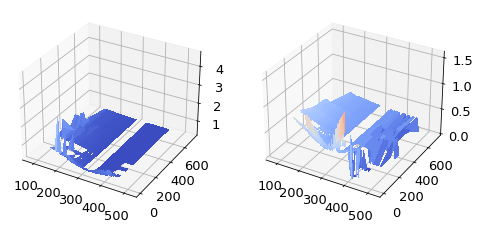

In [80]:
from datetime import datetime, date as datetime_date
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
from os.path import join
import re

PAR['vol_surface'] = {
    'data_dir': 'data',
    'data_file_name': 'MSFT_vol_surface_data.txt',
    'ticker': 'MSFT',  # vol surface for the calls/puts of this stock
    'figaspect': 0.5
}


def parse_vol_surface_data(all_html_data=None, par=None):
    """
    Parse options data from a concatenation of several html files.
    """
    vol_surface_data = []
    for single_html_file_as_a_string in re.findall('(<html.+?</html>)', all_html_data, flags=re.DOTALL):
        vol_surface_data.append(parse_yahoo_options_data(par=par, html_str=single_html_file_as_a_string))

    return vol_surface_data


def plot_vol_surface(par=None, vol_surface_data=None):
    """
    Plot volatility surface for both calls and puts
    """
    fig = plt.figure(figsize=plt.figaspect(par['figaspect']))

    for index_of_option, option_type in enumerate(['call', 'put']):
        ax = fig.add_subplot(1, 2, 1 + index_of_option, projection='3d')

        days_to_maturity_set = set()  # the set of all days_to_maturity values
        strike_set = set()  # the set of all strike price values
        impl_vol = dict()  # implied volatility by days_to_maturity and strike_price

        # --- extract data ---
        for d in vol_surface_data:
            options_data = d['options_data']
            post_market_date = datetime.fromtimestamp(d['post_market_time']).date()
            maturity_date = datetime_date(int(2000 + int(d['maturity'][:2])),
                                          int(d['maturity'][2:4].lstrip('0')),
                                          int(d['maturity'][4:6].lstrip('0'))) 
            days_to_maturity = (maturity_date - post_market_date).days
            days_to_maturity_set.add(days_to_maturity)

            if days_to_maturity not in options_data:
                impl_vol[days_to_maturity] = dict()
            for dat in options_data[option_type]:
                strike = int(dat['strike'])
                strike_set.add(strike)
                if strike not in impl_vol[days_to_maturity]:
                    impl_vol[days_to_maturity][strike] = dat['implied volatility']                

        # --- convert data for plotting ---
        # K: strike, T: time to maturity, IV: implied volatility
        K, T = np.meshgrid(sorted(list(strike_set)), sorted(list(days_to_maturity_set)))
        IV = []
        for index_of_row, row_of_k in enumerate(K):
            row_of_iv = []
            for index_of_column, k in enumerate(row_of_k):
                t_now = T[index_of_row][index_of_column]
                iv_now = impl_vol[t_now][k] if t_now in impl_vol and k in impl_vol[t_now] else None
                row_of_iv.append(iv_now)
            IV.append(row_of_iv)
        IV = np.array(IV)

        # --- plot data ---
        surf = ax.plot_surface(K, T, IV, rstride=1, cstride=1, cmap=cm.coolwarm,
                               linewidth=0, antialiased=False)

    plt.show()

        
def parse_data_and_plot_vol_surface(par=None):
    data_file_full_path = join(par['vol_surface']['data_dir'], par['vol_surface']['data_file_name'])
    html_data = open(data_file_full_path).read()
    vol_surface_data = parse_vol_surface_data(all_html_data=html_data, par=par['vol_smile'])
    plot_vol_surface(par=par['vol_surface'], vol_surface_data=vol_surface_data)
    
    
parse_data_and_plot_vol_surface(par=PAR)